## Setup and Imports

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from deep_translator import GoogleTranslator
import ast  # Used to safely evaluate string representations of lists
from tqdm.notebook import tqdm # For a nice progress bar

# Set plotting style for better visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

print("Libraries imported successfully!")

Libraries imported successfully!


## Load Raw Data

In [12]:
try:
    df_raw = pd.read_csv('sri_lanka_election_tweets_raw.csv')
    print("Raw CSV loaded successfully.")
    print(f"Shape of the dataset: {df_raw.shape}")
except FileNotFoundError:
    print("ERROR: 'sri_lanka_election_tweets_raw.csv' not found.")
    print("Please make sure the raw data file is in the same directory as this notebook.")

# Display the first few rows and info to see the initial state
if 'df_raw' in locals():
    print("\nInitial DataFrame Head:")
    display(df_raw.head())
    print("\nInitial DataFrame Info:")
    df_raw.info()

Raw CSV loaded successfully.
Shape of the dataset: (4788, 18)

Initial DataFrame Head:


,id,created_at,target_politicians,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1933559205618659553,Fri Jun 13 16:16:53 +0000 2025,NaN,Twitter for iPhone,@QUEENOFDBLUES1 Do you know the meaning of han...,NaN,NaN,NaN,NaN,en,0,0,1391100077972856834,False,[],['QUEENOFDBLUES1'],NaN,NaN
1,1933558233333215457,Fri Jun 13 16:13:01 +0000 2025,NaN,Twitter for iPhone,"Last day of saying ""Josh Hazelwood has never l...",NaN,NaN,NaN,NaN,en,0,0,1548553136930820096,False,['WtcFinal2025'],[],Bharat,NaN
2,1933558194485240163,Fri Jun 13 16:12:51 +0000 2025,NaN,Twitter for iPhone,@iraninarabic_ir 🇮🇷🇮🇱🚨🚨🚨: Israel may have fire...,NaN,NaN,NaN,NaN,en,1,0,1572477214762967042,False,[],['iraninarabic_ir'],NaN,NaN
3,1933557813542101397,Fri Jun 13 16:11:21 +0000 2025,NaN,Twitter for iPhone,@MuhammadSmiry 🇮🇷🇮🇱🚨🚨🚨: Israel may have fired ...,NaN,NaN,NaN,NaN,en,1,0,1572477214762967042,False,[],['MuhammadSmiry'],NaN,NaN
4,1933557682918609227,Fri Jun 13 16:10:50 +0000 2025,NaN,Twitter for iPhone,@jacksonhinklle 🇮🇷🇮🇱🚨🚨🚨: Israel may have fired...,NaN,NaN,NaN,NaN,en,0,0,1572477214762967042,False,[],['jacksonhinklle'],NaN,NaN



Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      4788 non-null   int64  
 1   created_at              4788 non-null   object 
 2   target_politicians      0 non-null      float64
 3   source                  4788 non-null   object 
 4   original_text           4788 non-null   object 
 5   clean_text              0 non-null      float64
 6   sentiment               0 non-null      float64
 7   polarity                0 non-null      float64
 8   subjectivity            0 non-null      float64
 9   lang                    4788 non-null   object 
 10  favorite_count          4788 non-null   int64  
 11  retweet_count           4788 non-null   int64  
 12  original_author         4788 non-null   int64  
 13  possibly_sensitive      4788 non-null   bool   
 14  hashtags       

## Define Dictionaries

In [13]:
# Keywords for each politician for precise tagging
politician_keywords = {
    'Anura Kumara Dissanayake': ['anura kumara', 'akd', '@anuradissanayake', 'anuradissanayake'],
    'Sajith Premadasa': ['sajith premadasa', 'sajith', '@sajithpremadasa'],
    'Ranil Wickremesinghe': ['ranil wickremesinghe', 'ranil', '@RW_UNP'],
    'Namal Rajapaksa': ['namal rajapaksa', 'namal', '@RajapaksaNamal']
}

# Emoticon and Singlish dictionaries
emoticons_happy = set([':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}', ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D', '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P', 'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)', '<3'])

emoticons_sad = set([':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<', ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c', ':c', ':{', '>:\\', ';('])

# Sinhala Pragmatics
singlish_happy = set(['hondai', 'honday', 'hondaiy', 'hondaii', 'niyamai', 'niyamay', 'supiri', 'supiriyak', 'supiriii', 'patta', 'maru', 'shok', 'shoi', 'ela', 'elakiri', 'elaa', 'jayawewa', 'jaya wewa', 'lassanai', 'lassanay', 'gammak', 'gammac', 'sira', 'siraa', 'ow', 'owu', 'ov', 'hari', 'aththa', 'aththac', 'subapathum', 'suba pathum', 'pissu kora', 'thanks', 'thankz', 'thnx', 'tnx'])

singlish_sad = set(['narakai', 'narakay', 'boru', 'boruwak', 'boruu', 'weradi', 'waradi', 'varadi', 'weradii', 'chater', 'chaater', 'chaa', 'epaa', 'epa', 'hora', 'horu', 'horakam', 'pissu', 'pisso', 'gon', 'gonn', 'gon haraka', 'pal horu', 'kalakanni', 'pala', 'palayan', 'aiyo', 'aiyoo', 'ane', 'apoi', 'ammapa', 'na', 'naa', 'ne', 'naha', 'nathuwa', 'nathi', 'neti', 'nathe'])

## Helper Functions

In [14]:
def get_target_politicians(text, keywords_dict):
    """Identifies which politician(s) are mentioned in a tweet."""
    if not isinstance(text, str):
        return []
    mentioned = []
    text_lower = text.lower()
    for politician, keywords in keywords_dict.items():
        if any(keyword in text_lower for keyword in keywords):
            mentioned.append(politician)
    return mentioned

def clean_text_for_blob(tweet_text):
    """Performs minimal cleaning on text before sending to TextBlob."""
    if not isinstance(tweet_text, str):
        return ""
    tweet_text = re.sub(r'https?:\/\/\S+', '', tweet_text)
    tweet_text = re.sub(r'@[A-Za-z0-9_]+', '', tweet_text)
    tweet_text = re.sub(r'#', '', tweet_text)
    return tweet_text

def calculate_custom_polarity(tweet_text):
    """
    Calculates a custom polarity score using Singlish and emoticons.
      It starts with a polarity of 0.0
      Each happy item adds +0.1
      Each sad item subtracts -0.1
    """
    if not isinstance(tweet_text, str):
        return 0.0
    polarity = 0.0
    text_lower = tweet_text.lower()
    for word in text_lower.split():
        if word in singlish_happy: polarity += 0.1
        elif word in singlish_sad: polarity -= 0.1
    for emoticon in emoticons_happy:
        if emoticon in text_lower: polarity += 0.1
    for emoticon in emoticons_sad:
        if emoticon in text_lower: polarity -= 0.1
    return max(min(polarity, 1.0), -1.0)

def get_hybrid_sentiment(text_for_blob, custom_polarity):
    """Combines TextBlob and custom polarities for a clamped, hybrid result."""
    analysis = TextBlob(text_for_blob)
    hybrid_polarity = analysis.sentiment.polarity + custom_polarity
    hybrid_polarity = max(min(hybrid_polarity, 1.0), -1.0)
    if hybrid_polarity > 0.05: sentiment = 'Positive'
    elif hybrid_polarity < -0.05: sentiment = 'Negative'
    else: sentiment = 'Neutral'
    return sentiment, hybrid_polarity, analysis.sentiment.subjectivity

def translate_text(text, target_lang='en'):
    """Translates text to English, returns original text on failure."""
    try:
        return GoogleTranslator(source='auto', target=target_lang).translate(text) or text
    except Exception:
        return text

print("Helper functions defined and ready.")

Helper functions defined and ready.


# Clean up and prepare the data for processing

In [15]:
# Create a copy to work on, preserving the original raw data
df = df_raw.copy()

# Ensure 'original_text' has no missing values (fill with empty string)
df['original_text'] = df['original_text'].fillna('')

## Tag Politicians and Filter Irrelevant Tweets

In [16]:
print("Tagging politicians in each tweet...")
# Apply our function to identify the politician(s) mentioned in each tweet
df['target_politicians'] = df['original_text'].apply(lambda text: get_target_politicians(text, politician_keywords))

# Now, filter out tweets that are not about our target politicians
original_rows = len(df)
# This line keeps only the rows where the 'target_politicians' list is NOT empty
df = df[df['target_politicians'].apply(len) > 0].reset_index(drop=True)

print(f"Removed {original_rows - len(df)} tweets that didn't mention any target politicians.")
print(f"Remaining tweets for analysis: {len(df)}")

Tagging politicians in each tweet...
Removed 3409 tweets that didn't mention any target politicians.
Remaining tweets for analysis: 1379


In [17]:
df

,id,created_at,target_politicians,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1933555774984245308,Fri Jun 13 16:03:15 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@GurenDingin5 Thanks. I enjoy writing the page...,NaN,NaN,NaN,NaN,en,1,0,344365428,False,[],['GurenDingin5'],Land of Lagom,NaN
1,1933549625275003025,Fri Jun 13 15:38:48 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@DON_AKD @IsItOutEa @EASPORTSCollege They like...,NaN,NaN,NaN,NaN,en,1,0,1496700372659826688,False,[],"['DON_AKD', 'IsItOutEa', 'EASPORTSCollege']",NaN,NaN
2,1933547017755894258,Fri Jun 13 15:28:27 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@NoCCPGenocide @One_BCHQ I agree we need to se...,NaN,NaN,NaN,NaN,en,0,0,1622360846398799873,False,[],"['NoCCPGenocide', 'One_BCHQ', 'bcndp']","British Columbia, Canada",NaN
3,1933545480300249268,Fri Jun 13 15:22:20 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,Like this tweet to piss off a Ranil Rajapaksha...,NaN,NaN,NaN,NaN,en,11,0,1148434888904679424,False,[],[],NaN,NaN
4,1933533234442203589,Fri Jun 13 14:33:41 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,The Business Forum organised by the Associatio...,NaN,NaN,NaN,NaN,en,0,0,1190901200415154176,False,"['lka', 'SriLanka', 'Germany']",[],Sri Lanka,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1928507090659692608,Fri May 30 17:41:34 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,the initiator of this fight against corruption...,NaN,NaN,NaN,NaN,en,4,0,1522215769626447875,False,[],[],NaN,NaN
1375,1928506957603725543,Fri May 30 17:41:03 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,All these Ranilists are trying their level bes...,NaN,NaN,NaN,NaN,en,12,1,1522215769626447875,False,[],[],NaN,NaN
1376,1928504374432591985,Fri May 30 17:30:47 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,@nadeesha111 @UNPunOfficial If Ranil is the on...,NaN,NaN,NaN,NaN,en,1,0,1522215769626447875,False,[],"['nadeesha111', 'UNPunOfficial']",NaN,NaN
1377,1928498217639096691,Fri May 30 17:06:19 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,🚨 Germany to press Sri Lanka on human rights d...,NaN,NaN,NaN,NaN,en,4,3,211116487,False,[],[],NaN,NaN


## Calculate Hybrid Sentiment for Each Relevant Tweet
- First, capture the local sentiment cues from the original text (Singlish/emoticons).
- Then, translate the remaining text for the general-purpose English analyzer (TextBlob).
- Finally, combine both results for a more accurate, hybrid score.

In [18]:
print("\nProcessing tweets to calculate hybrid sentiment ...")
# tqdm will create a nice progress bar for us
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    original_text = row['original_text']
    lang = row['lang']

    # Apply the full hybrid sentiment logic
    custom_polarity = calculate_custom_polarity(original_text)
    cleaned_for_blob = clean_text_for_blob(original_text)

    text_for_analysis = cleaned_for_blob
    if lang == 'si':
        # This step can be slow due to the translation API call
        text_for_analysis = translate_text(cleaned_for_blob)

    sentiment, final_polarity, subjectivity = get_hybrid_sentiment(text_for_analysis, custom_polarity)

    # Populate the empty columns in our DataFrame with the results
    df.at[index, 'clean_text'] = cleaned_for_blob
    df.at[index, 'sentiment'] = sentiment
    df.at[index, 'polarity'] = final_polarity
    df.at[index, 'subjectivity'] = subjectivity

print("\nProcessing complete!")



Processing tweets to calculate hybrid sentiment ...


  0%|          | 0/1379 [00:00<?, ?it/s]

C:\conda_temp\ipykernel_31500\3720288770.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value ' Thanks. I enjoy writing the pages akd see them come to life. Sadly there is so much stuff that i wish could be drawn' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'clean_text'] = cleaned_for_blob
C:\conda_temp\ipykernel_31500\3720288770.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'sentiment'] = sentiment



Processing complete!


In [19]:
df

,id,created_at,target_politicians,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1933555774984245308,Fri Jun 13 16:03:15 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@GurenDingin5 Thanks. I enjoy writing the page...,Thanks. I enjoy writing the pages akd see the...,Positive,0.075000,0.475000,en,1,0,344365428,False,[],['GurenDingin5'],Land of Lagom,NaN
1,1933549625275003025,Fri Jun 13 15:38:48 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@DON_AKD @IsItOutEa @EASPORTSCollege They like...,They like to withhold information so that y...,Neutral,0.000000,0.000000,en,1,0,1496700372659826688,False,[],"['DON_AKD', 'IsItOutEa', 'EASPORTSCollege']",NaN,NaN
2,1933547017755894258,Fri Jun 13 15:28:27 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,@NoCCPGenocide @One_BCHQ I agree we need to se...,I agree we need to see some rubber on the ro...,Negative,-0.097222,0.313889,en,0,0,1622360846398799873,False,[],"['NoCCPGenocide', 'One_BCHQ', 'bcndp']","British Columbia, Canada",NaN
3,1933545480300249268,Fri Jun 13 15:22:20 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,Like this tweet to piss off a Ranil Rajapaksha...,Like this tweet to piss off a Ranil Rajapaksha...,Neutral,0.000000,0.000000,en,11,0,1148434888904679424,False,[],[],NaN,NaN
4,1933533234442203589,Fri Jun 13 14:33:41 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,The Business Forum organised by the Associatio...,The Business Forum organised by the Associatio...,Neutral,0.000000,0.000000,en,0,0,1190901200415154176,False,"['lka', 'SriLanka', 'Germany']",[],Sri Lanka,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1928507090659692608,Fri May 30 17:41:34 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,the initiator of this fight against corruption...,the initiator of this fight against corruption...,Neutral,0.000000,0.000000,en,4,0,1522215769626447875,False,[],[],NaN,NaN
1375,1928506957603725543,Fri May 30 17:41:03 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,All these Ranilists are trying their level bes...,All these Ranilists are trying their level bes...,Positive,0.500000,0.300000,en,12,1,1522215769626447875,False,[],[],NaN,NaN
1376,1928504374432591985,Fri May 30 17:30:47 +0000 2025,[Ranil Wickremesinghe],Twitter for iPhone,@nadeesha111 @UNPunOfficial If Ranil is the on...,If Ranil is the one who's the initiator of a...,Positive,0.125000,0.291667,en,1,0,1522215769626447875,False,[],"['nadeesha111', 'UNPunOfficial']",NaN,NaN
1377,1928498217639096691,Fri May 30 17:06:19 +0000 2025,[Anura Kumara Dissanayake],Twitter for iPhone,🚨 Germany to press Sri Lanka on human rights d...,🚨 Germany to press Sri Lanka on human rights d...,Positive,0.072222,0.222222,en,4,3,211116487,False,[],[],NaN,NaN


## Explode Data for Per-Candidate Analysis

In [23]:
# This creates a separate row for each politician mentioned in a tweet.
df_exploded = df.explode('target_politicians')

print(f"Number of rows before exploding: {len(df)}")
print(f"Number of rows after exploding: {len(df_exploded)}")


# Feature Engineering: Create Engagement and Weighted Polarity Scores

# Calculate a simple engagement score. We add 1 to ensure that tweets with zero
# likes/retweets still have their base polarity score counted (polarity * 1).
df_exploded['engagement'] = df_exploded['retweet_count'] + df_exploded['favorite_count'] + 1

# Calculate the weighted polarity. This is our key predictive metric.
df_exploded['weighted_polarity'] = df_exploded['polarity'] * df_exploded['engagement']

print("\nCreated new metrics: 'engagement' and 'weighted_polarity'...")


Number of rows before exploding: 1379
Number of rows after exploding: 1460

Created new metrics: 'engagement' and 'weighted_polarity'...


## Save Cleaned Data

In [25]:
# Save the Final, Analysis-Ready DataFrame
output_filename = 'sri_lanka_election_tweets_analysis_ready.csv'
df_exploded.to_csv(output_filename, index=False)
print(f"Final analysis-ready data saved to '{output_filename}'")


# Display the results to verify
print("\nHead of the Final Analysis-Ready DataFrame:")
display(df_exploded[['target_politicians', 'polarity', 'retweet_count', 'favorite_count', 'engagement', 'weighted_polarity']])

Final analysis-ready data saved to 'sri_lanka_election_tweets_analysis_ready.csv'

Head of the Final Analysis-Ready DataFrame:


,target_politicians,polarity,retweet_count,favorite_count,engagement,weighted_polarity
0,Anura Kumara Dissanayake,0.075000,0,1,2,0.150000
1,Anura Kumara Dissanayake,0.000000,0,1,2,0.000000
2,Anura Kumara Dissanayake,-0.097222,0,0,1,-0.097222
3,Ranil Wickremesinghe,0.000000,0,11,12,0.000000
4,Anura Kumara Dissanayake,0.000000,0,0,1,0.000000
...,...,...,...,...,...,...
1374,Ranil Wickremesinghe,0.000000,0,4,5,0.000000
1375,Ranil Wickremesinghe,0.500000,1,12,14,7.000000
1376,Ranil Wickremesinghe,0.125000,0,1,2,0.250000
1377,Anura Kumara Dissanayake,0.072222,3,4,8,0.577778


## Visualize Sentiment Distribution

--- Sentiment Counts per Politician ---
sentiment                 Positive  Neutral  Negative
target_politicians                                   
Anura Kumara Dissanayake       362      397       193
Namal Rajapaksa                 27       36        12
Ranil Wickremesinghe           110      134        47
Sajith Premadasa                73       50        19

--- Visualizing Sentiment Distribution ---


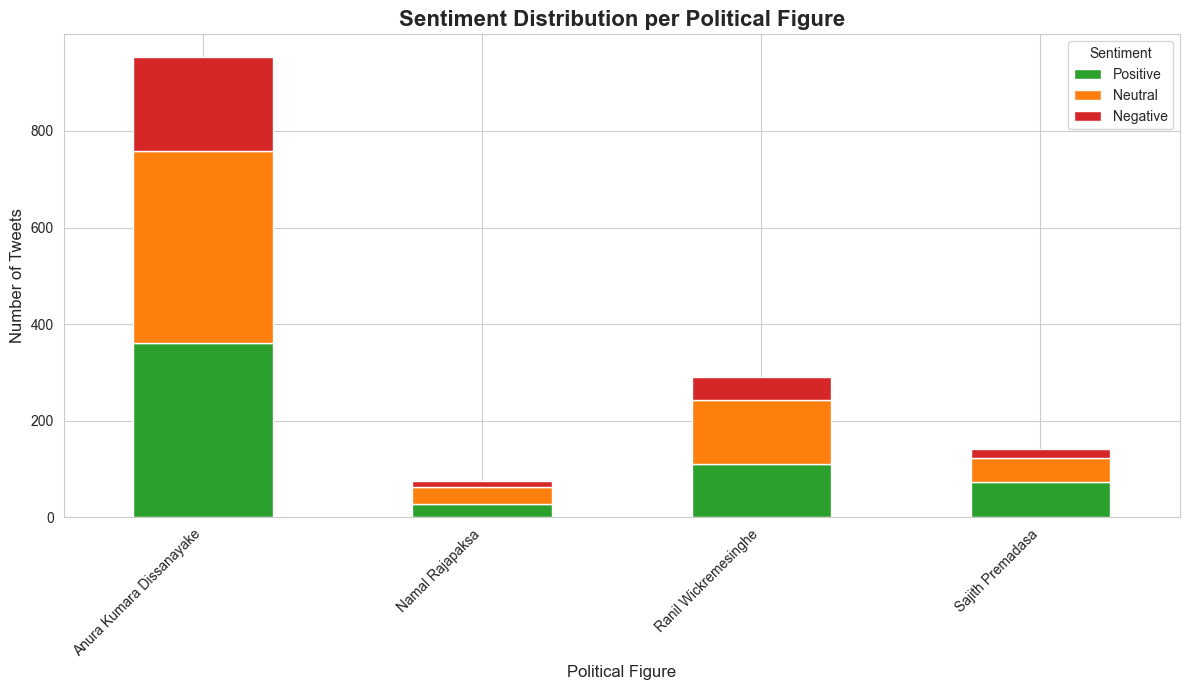

In [26]:
# PREPARE THE DATA: Group by politician and sentiment, then count the occurrences.
sentiment_dist = df_exploded.groupby(['target_politicians', 'sentiment']).size().unstack(fill_value=0)

# Reorder columns for a more intuitive chart (Positive -> Neutral -> Negative)
for col in ['Positive', 'Neutral', 'Negative']:
    if col not in sentiment_dist.columns:
        sentiment_dist[col] = 0
sentiment_dist = sentiment_dist[['Positive', 'Neutral', 'Negative']]

print("--- Sentiment Counts per Politician ---")
print(sentiment_dist)


# VISUALIZE THE DATA: Create a stacked bar chart.
print("\n--- Visualizing Sentiment Distribution ---")
sentiment_dist.plot(kind='bar', 
                    stacked=True,
                    color=['#2ca02c', '#ff7f0e', '#d62728'], # Green, Orange, Red
                    figsize=(12, 7))

# Add titles and labels for clarity
plt.title('Sentiment Distribution per Political Figure', fontsize=16, fontweight='bold')
plt.xlabel('Political Figure', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()

# Display the plot
plt.show()


--- Chart 2: Engagement-Weighted Sentiment Score ---
This chart amplifies sentiment by how many likes and retweets a tweet received.
It's a better measure of impactful public opinion.


C:\conda_temp\ipykernel_31500\3776370032.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weighted_score.index, y=weighted_score.values, palette=colors)


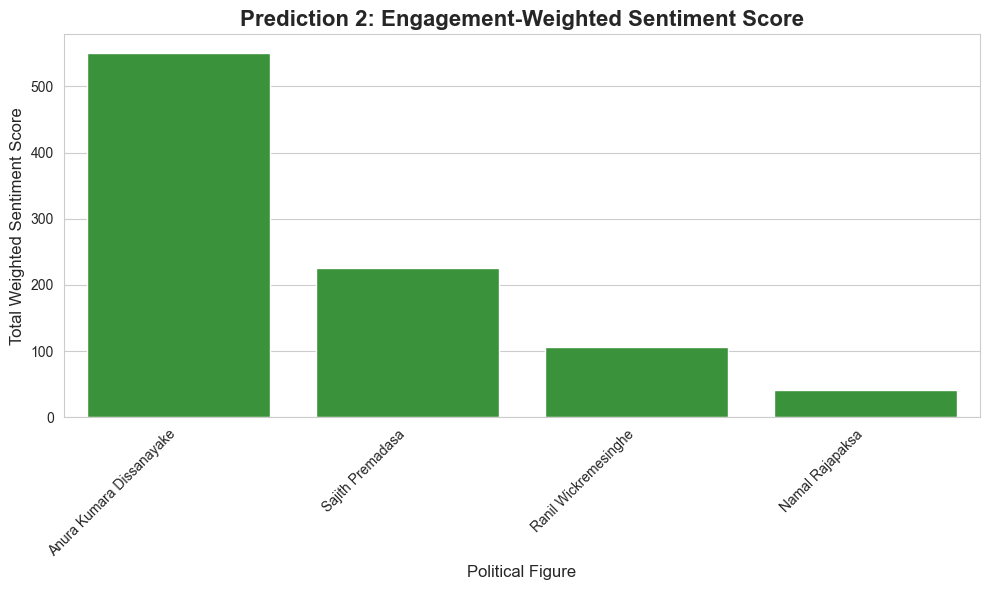


--- Total Weighted Sentiment Scores (Prediction 2) ---
target_politicians
Anura Kumara Dissanayake    550.817218
Sajith Premadasa            225.633224
Ranil Wickremesinghe        106.830013
Namal Rajapaksa              41.536010
Name: weighted_polarity, dtype: float64


In [27]:
print("\n--- Chart 2: Engagement-Weighted Sentiment Score ---")
print("This chart amplifies sentiment by how many likes and retweets a tweet received.")
print("It's a better measure of impactful public opinion.")

# Create the 'engagement' score. We add 1 to avoid multiplying by zero.
df_exploded['engagement'] = df_exploded['favorite_count'] + df_exploded['retweet_count'] + 1

# Create the weighted polarity score
df_exploded['weighted_polarity'] = df_exploded['polarity'] * df_exploded['engagement']

# Group by politician and calculate the SUM of these weighted scores
weighted_score = df_exploded.groupby('target_politicians')['weighted_polarity'].sum().sort_values(ascending=False)

# Create a color palette
colors = ['#2ca02c' if x > 0 else '#d62728' for x in weighted_score.values]

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=weighted_score.index, y=weighted_score.values, palette=colors)

plt.title('Prediction 2: Engagement-Weighted Sentiment Score', fontsize=16, fontweight='bold')
plt.xlabel('Political Figure', fontsize=12)
plt.ylabel('Total Weighted Sentiment Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the exact scores for clarity
print("\n--- Total Weighted Sentiment Scores (Prediction 2) ---")
print(weighted_score)